# K-nearest Neighbor (Burak Turan, 584171)


Das K-nearest neighbor (KNN) Regressionsmodell ist eine einfache, aber effektive Methode des maschinellen Lernens. Es basiert auf der Annahme, dass ähnliche Datenpunkte tendenziell auch ähnliche Zielwerte haben. KNN gehört zur Kategorie des überwachten Lernens und findet Anwendung sowohl bei Klassifikations- als auch bei Regressionsproblemen. Im Falle der Regression sucht das KNN-Modell die k nächsten Nachbarn eines neuen Datenpunkts im n-dimensionalen Raum und verwendet den Durchschnitt der Zielwerte dieser Nachbarn, um den Zielwert des neuen Punkts vorherzusagen.

**Funktionsweise des KNN-Regressionsmodells**
Das KNN-Regressionsmodell sagt den Zielwert eines neuen Datenpunkts basierend auf den k ähnlichsten (nächstgelegenen) Datenpunkten voraus. Um diese Ähnlichkeit zu messen, wird eine Distanzmetrik verwendet. Zu den gängigen Metriken gehören die euklidische Distanz, die Manhattan-Distanz und die Minkowski-Distanz.

**Euklidische Distanz:** Sie misst die direkte, gerade Entfernung zwischen zwei Punkten im Raum und eignet sich besonders gut für gleichmäßig verteilte Daten.

**Manhattan-Distanz:** Diese Metrik misst die Entfernung entlang der Achsen des Raumes, ähnlich wie man in einem Gitter von einer Kreuzung zur nächsten geht. Sie wird oft für ungleichmäßig verteilte Daten verwendet.

**Minkowski-Distanz:** Diese Metrik ist eine Verallgemeinerung der euklidischen und Manhattan-Distanz und kann je nach Anwendung flexibel angepasst werden, um die geometrischen Eigenschaften der Daten besser zu berücksichtigen.

**Auswahl von k:**
Die Wahl des Parameters k (Anzahl der nächsten Nachbarn) ist entscheidend für die Modellleistung. Ein zu kleiner Wert von k kann dazu führen, dass das Modell auf Rauschen in den Daten überreagiert, was zu Overfitting führt. Ein zu großer Wert von k kann hingegen wichtige Muster in den Daten "überglätten" und nicht erfassen. In der Praxis wird der optimale Wert von k häufig durch Kreuzvalidierung ermittelt.

**Vorteile des KNN-Modells**
- Einfachheit: KNN ist leicht zu verstehen und umzusetzen, da es keine Annahmen über die Verteilung der Daten macht und rein datengetrieben arbeitet.

- Flexibilität: Es ist sowohl für Klassifikations- als auch für Regressionsprobleme geeignet und kann an unterschiedliche Problemstellungen angepasst werden.

- Keine explizite Modellbildung: Da KNN zu den sogenannten „Lazy Learners“ gehört, erfolgt die Modellbildung erst während der Vorhersage. Das macht KNN in bestimmten Szenarien effizient.

**Nachteile des KNN-Modells**
- Rechenintensiv: Da das Modell bei jeder Vorhersage die Distanzen zu allen vorhandenen Datenpunkten berechnen muss, kann es bei großen Datensätzen sehr rechenaufwendig sein.

- Empfindlichkeit gegenüber der Skalierung der Daten: KNN ist stark von der Skalierung der Daten abhängig. Variablen mit größeren Wertebereichen dominieren die Distanzberechnungen, weshalb eine Normalisierung oder Standardisierung der Daten oft notwendig ist.

- Gleicher Einfluss der Nachbarn: In der Standardversion von KNN haben alle k Nachbarn den gleichen Einfluss auf die Vorhersage, unabhängig davon, wie nah oder weit sie vom Zielpunkt entfernt sind.


**Quellen:**

Bishop, C. M. (2006). Pattern Recognition and Machine Learning. Springer: Dieses Standardwerk erklärt detailliert die mathematischen Grundlagen von KNN und vielen anderen Machine-Learning-Algorithmen, einschließlich Regressionsverfahren.

Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer: Ein weiteres grundlegendes Werk, das umfassend verschiedene Machine-Learning-Verfahren erklärt, einschließlich der KNN-Regression.

Duda, R. O., Hart, P. E., & Stork, D. G. (2001). Pattern Classification. Wiley-Interscience: Dieses Buch bietet eine Einführung in Klassifikations- und Regressionsmethoden wie KNN.

Cover, T. M., & Hart, P. E. (1967). Nearest Neighbor Pattern Classification. IEEE Transactions on Information Theory: Das Originalpaper über das KNN-Verfahren, das die Grundidee der Methode beschreibt.

Scikit-learn (2024). K-nearest neighbors algorithm. Online-Dokumentation von Scikit-learn: Diese Ressource bietet eine umfassende Implementierung des KNN-Algorithmus und beschreibt sowohl die Klassifikations- als auch die Regressionsvariante. Es enthält praktische Beispiele und Hinweise zur Hyperparameter-Auswahl und Datenvorverarbeitung.

Altman, N. S. (1992). An Introduction to Kernel and Nearest-Neighbor Nonparametric Regression. The American Statistician: Dieser Artikel bietet eine gute Einführung in die Anwendung von KNN für Regressionsprobleme.

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit

## Daten laden (übernahme aus PreProcessing)

In [11]:
# Laden des Datensatzes
data_cleaned = "../data/cleaned_train.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

## Features

In [12]:
# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday'] #lag1 und lag7 entfernt
# Bereits encodierte Features
already_encoded_features = ['Open', 'Promo', 'promo2']
# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['Store', 'DayOfWeek', 'StoreType', 'StateHoliday','Assortment']

## Split (übernahme aus PreProcessing)

In [13]:
# Datensatz sortieren, falls nicht bereits geschehen
data = data.sort_values('Date')

# auch noch Text hinzufügen
data = data[data ['Open']!=0]
data = data[data ['Sales']>0]

# Zielvariable und Features definieren
X = data.drop(['Sales', 'Date', 'Open'], axis=1)  # 'Date' wird entfernt, wenn es keine erklärende Variable ist
y = data['Sales']

# Bestimme die Grenze für 80% Training und 20% Test
train_size = int(len(data) * 0.8)
# Aufteilen in Trainings- und Test-Datensätze
train = data.iloc[:train_size]
test = data.iloc[train_size:]
# Ziel- und Eingabedaten für Training und Test
X_train = train.drop('Sales', axis=1)
y_train = train['Sales']
X_test = test.drop('Sales', axis=1)
y_test = test['Sales']

## Visualisieren 

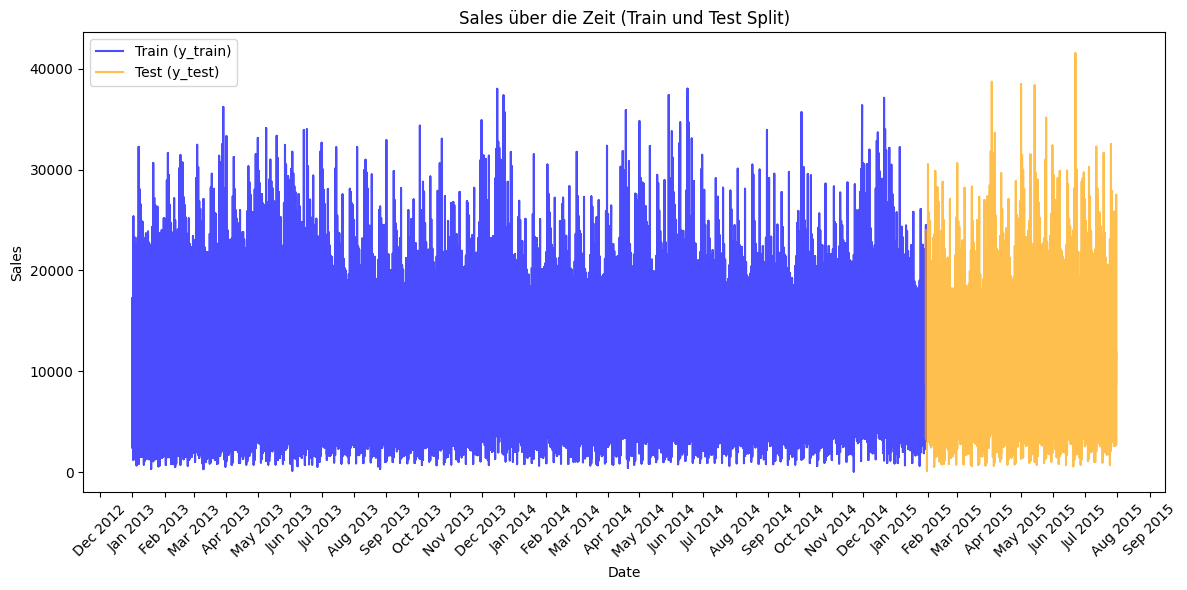

In [14]:
# Konvertiere die 'Date'-Spalte in datetime mit der .loc Methode
X_train.loc[:, 'Date'] = pd.to_datetime(X_train['Date'], errors='coerce')
X_test.loc[:, 'Date'] = pd.to_datetime(X_test['Date'], errors='coerce')

# Liniendiagramm erstellen, um die wahren Sales in y_train und y_test zu visualisieren
plt.figure(figsize=(12, 6))

# Plot für die Trainingsdaten (y_train)
plt.plot(X_train['Date'], y_train, label='Train (y_train)', color='blue', alpha=0.7)

# Plot für die Testdaten (y_test)
plt.plot(X_test['Date'], y_test, label='Test (y_test)', color='orange', alpha=0.7)

# Achsenbeschriftungen
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales über die Zeit (Train und Test Split)')

# X-Achse mit Datumsformatierung (Monat und Jahr)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)  # Drehe die x-Achsenbeschriftung für bessere Lesbarkeit

# Legende
plt.legend()

# Layout anpassen und Diagramm anzeigen
plt.tight_layout()
plt.show()

## Metrik (übernahme aus PreProcessing)

In [15]:
# Angepasste RMSPE-Funktion, die Tage mit 0 Sales ignoriert
def rmspe(y_true, y_pred):
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))
# RMSPE als Scorer definieren
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

## Kreuzvalidierung (übernahme aus PreProcessing)

In [16]:
# 5-fold TimeSeries Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

## Pre-Processing (übernahme aus PreProcessing)

In [39]:
# Erstelle den Preprocessor für numerische und kategorische Features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('enc', 'passthrough', already_encoded_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)
    ])

## KNN

Im Folgenden wird eine Pipeline für das maschinelle Lernen mit dem K-Nearest Neighbors (KNN) Regressor vorgestellt, die speziell für eine Zeitreihenvorhersage entwickelt wurde. Diese Pipeline kombiniert die Datenvorverarbeitung und das eigentliche KNN-Modell in einem strukturierten Workflow. Dabei sorgt die Pipeline dafür, dass die notwendigen Vorverarbeitungsschritte, wie etwa Skalierung oder Feature-Transformation, einheitlich sowohl auf die Trainings- als auch auf die Testdaten angewendet werden.

Zur Beurteilung der Modellleistung wird eine zeitreihen-spezifische Kreuzvalidierung mithilfe von TimeSeriesSplit eingesetzt. Dies stellt sicher, dass die Reihenfolge der Daten gewahrt bleibt und zukünftige Werte niemals zur Vorhersage früherer verwendet werden. Zusätzlich wird ein benutzerdefinierter Scorer (Root Mean Squared Percentage Error - RMSPE) eingesetzt, um die Genauigkeit des Modells zu bewerten. Diese Methode eignet sich besonders gut für Probleme, bei denen sowohl nichtlineare Beziehungen als auch zeitliche Muster eine Rolle spielen, wie etwa bei der Vorhersage von Verkaufszahlen oder anderen ökonomischen Indikatoren.

In [41]:
# Erstelle die Pipeline für KNN
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=5)) # Hyperparameter zum anpassen hoch und runter
])

# Cross-Validation mit TimeSeriesSplit
cv_scores_knn = cross_val_score(pipeline_knn, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

KeyboardInterrupt: 

In [19]:
pipeline_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365',
                                                   'days_since_last_holiday',
                                                   'days_until_next_holiday',
                                                   'Open', 'Promo', 'promo2']),
                                                 ('enc', 'passthrough',
                                                  ['Open', 'Promo', 'promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Store', 'DayOfWeek',
                                                   'StoreType', 'StateHoliday',
                                                   'Assortment'])])),
                ('model', KNeighborsRegressor())])

## Die nachfolgenden zwei Zellen waren die ersten Versuche mit erfolgreichen Augaben. Jedoch liefern diese Ausgaben keine aussagekräftige Ergebnisse, da keine richtiges Hyperparamtertuning mit GridSearchCV, RandomizedSearchCV oder Optuna erfolgt ist. Anzumerken ist, dass zu diesem Zeitpunkt keine Einigung über die Features herrschte. Daher sind die Features ('fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday') an der Stelle nicht mit in die Ausgabe miteingeflossen.

### 1. Versuch mit Timesseries Cross Validation und n_neighbors = 2

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer  # make_scorer importieren
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np

# Laden des Datensatzes
data_cleaned = "../data/cleaned_train.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

# Datensatz sortieren, falls nicht bereits geschehen
data = data.sort_values('Date')

# auch noch Text hinzufügen
data = data[data ['Open']!=0]
data = data[data ['Sales']>0]

# Zielvariable und Features definieren
X = data.drop(['Sales', 'Date', 'Open'], axis=1)  # 'Date' wird entfernt, wenn es keine erklärende Variable ist
y = data['Sales']

# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year']
# Bereits encodierte Features
already_encoded_features = ['Open', 'Promo', 'promo2']
# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['Store', 'DayOfWeek', 'StoreType', 'StateHoliday','Assortment']

df = pd.DataFrame(data)
# Bestimme die Grenze für 80% Training und 20% Test
train_size = int(len(df) * 0.8)
# Aufteilen in Trainings- und Test-Datensätze
train = df.iloc[:train_size]
test = df.iloc[train_size:]
# Ziel- und Eingabedaten für Training und Test
X_train = train.drop('Sales', axis=1)
y_train = train['Sales']
X_test = test.drop('Sales', axis=1)
y_test = test['Sales']

# Angepasste RMSPE-Funktion, die Tage mit 0 Sales ignoriert
def rmspe(y_true, y_pred):
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))
# RMSPE als Scorer definieren
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Erstelle den Preprocessor für numerische und kategorische Features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features + already_encoded_features),
        ('enc', 'passthrough', already_encoded_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)
    ])
# Erstelle die Pipeline für KNN
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=2)) # Hyperparameter zum anpassen hoch und runter
])


# Trainiere das KNN-Modell
pipeline_knn.fit(X_train, y_train)
# 5-fold TimeSeries Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
# Cross-Validation mit TimeSeriesSplit
cv_scores_knn = cross_val_score(pipeline_knn, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

# Durchschnittlichen RMSPE berechnen
mean_rmspe_knn = np.mean(cv_scores_knn)
print("Durchschnittlicher RMSPE (KNN, TimeSeries Cross-Validation):", mean_rmspe_knn)
# 3. Vorhersagen auf dem Testset machen
y_pred_knn = pipeline_knn.predict(X_test)
# Test RMSPE berechnen
test_rmspe_knn = rmspe(y_test, y_pred_knn)
print("Test RMSPE (KNN):", test_rmspe_knn)

Durchschnittlicher RMSPE (KNN, TimeSeries Cross-Validation): -0.30225682404536586
Test RMSPE (KNN): 0.24405497742782506


### 2. Versuch Hyperparametertuning (n_neighbors = 6)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
import pandas as pd
import numpy as np

# Laden des Datensatzes
data_cleaned = "../data/cleaned_train.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)
# Datensatz sortieren, falls nicht bereits geschehen
data = data.sort_values('Date')

# auch noch Text hinzufügen
data = data[data ['Open']!=0]
data = data[data ['Sales']>0]

# Zielvariable und Features definieren
X = data.drop(['Sales', 'Date', 'Open'], axis=1)  # 'Date' wird entfernt, wenn es keine erklärende Variable ist
y = data['Sales']
# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year']
# Bereits encodierte Features
already_encoded_features = ['Open', 'Promo', 'promo2']
# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['Store', 'DayOfWeek', 'StoreType', 'StateHoliday','Assortment']

# 1. Datensatz aufteilen in Trainings- und Testdaten
df = pd.DataFrame(data)

# Bestimme die Grenze für 80% Training und 20% Test
train_size = int(len(df) * 0.8)
# Aufteilen in Trainings- und Test-Datensätze
train = df.iloc[:train_size]
test = df.iloc[train_size:]
# Ziel- und Eingabedaten für Training und Test
X_train = train.drop('Sales', axis=1)
y_train = train['Sales']
X_test = test.drop('Sales', axis=1)
y_test = test['Sales']

# Angepasste RMSPE-Funktion, die Tage mit 0 Sales ignoriert
def rmspe(y_true, y_pred):
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))
# RMSPE als Scorer definieren
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# Erstelle den Preprocessor für numerische und kategorische Features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features + already_encoded_features),
        ('enc', 'passthrough', already_encoded_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)
    ])
# Erstelle die Pipeline für KNN
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=6))  #hier n_neighbors anpassen
])

# Hyperparameter-Tuning mit GridSearchCV
param_grid = {
    'model__n_neighbors': [3, 5, 10, 15],   # Verschiedene Werte für k
    'model__weights': ['uniform', 'distance'],  # Gewichtete oder uniforme Nachbarn
    'model__metric': ['euclidean', 'manhattan']  # Verschiedene Distanzmetriken
}
# Trainiere das KNN-Modell
pipeline_knn.fit(X_train, y_train)
# 5-fold TimeSeries Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
# Cross-Validation mit TimeSeriesSplit
cv_scores_knn = cross_val_score(pipeline_knn, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

# Durchschnittlichen RMSPE berechnen
mean_rmspe_knn = np.mean(cv_scores_knn)
print("Durchschnittlicher RMSPE (KNN, TimeSeries Cross-Validation):", mean_rmspe_knn)
# 3. Vorhersagen auf dem Testset machen
y_pred_knn = pipeline_knn.predict(X_test)
# Test RMSPE berechnen
test_rmspe_knn = rmspe(y_test, y_pred_knn)
print("Test RMSPE (KNN):", test_rmspe_knn)


Durchschnittlicher RMSPE (KNN, TimeSeries Cross-Validation): -0.2794781299440422
Test RMSPE (KNN): 0.22253414113163228


**1. Durchschnittlicher RMSPE in der Kreuzvalidierung:**

Der neue RMSPE-Wert für die Kreuzvalidierung beträgt jetzt -0.2795, was eine kleine Verbesserung gegenüber dem vorherigen Wert (-0.3023) ist. Das bedeutet, dass das Modell jetzt besser darin ist, die Fehler zu minimieren. Ein niedrigerer RMSPE bedeutet, dass die Vorhersagen im Durchschnitt näher an den tatsächlichen Werten liegen.


**2. RMSPE im Testdatensatz:**

Der neue RMSPE auf dem Testdatensatz liegt bei 0.2225, was ebenfalls besser ist als der frühere Wert (0.2441). Dies zeigt, dass das Modell nun auf unbekannten Daten (dem Testdatensatz) genauer vorhersagt. Du siehst also eine Verbesserung sowohl im Training als auch im Test.


**3. Was die Ergebnisse bedeuten:**

**Verbesserung des RMSPE-Werts:**
Der RMSPE-Wert ist leicht gesunken, was darauf hinweist, dass das Modell jetzt etwas besser arbeitet. Kleinere Anpassungen an den Parametern, wie die Anzahl der Nachbarn, haben offenbar eine positive Auswirkung.

## Als nächster Schritt müssten nun Hyperparametertuning mit GridSearchCV, RandomizedSearchCV oder Optuna erfolgen

## Hyperparameter Optimierung

### RandomizedSearch CV

Im folgenden Code wird RandomizedSearchCV verwendet, um die besten Hyperparameter für das KNN-Modell zu ermitteln. Diese Methode ermöglicht eine effiziente Suche innerhalb eines festgelegten Hyperparameter-Raums, ohne alle möglichen Kombinationen durchzuprobieren. Stattdessen werden nur zufällig ausgewählte Kombinationen getestet, was den Rechenaufwand erheblich reduziert. Der gesamte Prozess wird in eine Pipeline eingebettet, die sowohl die Datenvorverarbeitung als auch die Modellanpassung umfasst.

Zuerst wird der KNN-Regressor in die Pipeline integriert, um die ordnungsgemäße Vorverarbeitung der Daten sicherzustellen. Danach wird ein Parameterraum für die Hyperparameter-Suche festgelegt, der beispielsweise die Anzahl der Nachbarn, die Gewichtung dieser Nachbarn und die Wahl der Distanzmetrik (Manhattan oder euklidische Distanz) umfasst. Mithilfe von RandomizedSearchCV wird das Modell dann in einer zeitspezifischen Kreuzvalidierung (TimeSeriesSplit) evaluiert, um die optimalen Hyperparameter zu bestimmen. Zur Messung der Modellgüte wird dabei ein benutzerdefinierter RMSPE-Scorer (Root Mean Squared Percentage Error) verwendet.

Im Anschluss erfolgen Vorhersagen sowohl für die Trainings- als auch für die Testdaten. Der RMSPE-Wert wird dann zur Bewertung der Modellleistung herangezogen. Schließlich werden die optimalen Hyperparameter sowie die RMSPE-Werte für das Training und den Test ausgegeben, um eine transparente Beurteilung der Modellperformance zu ermöglichen.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

# KNeighborsRegressor-Modell
knn_regressor = KNeighborsRegressor()

# Pipeline für KNN-Regression
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', knn_regressor)
])

# Parameterräume für RandomizedSearchCV (für KNN)
param_distributions = {
    'model__n_neighbors': np.arange(1, 30),  # Anzahl der Nachbarn
    'model__weights': ['uniform', 'distance'],  # Gewichtung der Nachbarn
    'model__p': [1, 2]  # p = 1 (Manhattan), p = 2 (Euklidisch)
}

# RandomizedSearchCV mit KNN
random_search = RandomizedSearchCV(pipeline_knn, param_distributions, n_iter=50, cv=tscv, 
                                   scoring=rmspe_scorer, random_state=42, n_jobs=1, verbose=1)

# Fitting des RandomizedSearchCV
random_search.fit(X_train, y_train)

# Vorhersagen auf Trainings- und Testdaten
y_pred_train = random_search.predict(X_train)
y_pred_test = random_search.predict(X_test)

# RMSPE-Berechnung für Training und Test
rmspe_train_random = rmspe(y_train, y_pred_train)
rmspe_test_random = rmspe(y_test, y_pred_test)

# Ausgabe der besten Parameter und der RMSPE-Werte
print("Beste Parameter:", random_search.best_params_)
print(f"Train RMSPE: {rmspe_train_random:.4f}")
print(f"Test RMSPE: {rmspe_test_random:.4f}")


### Optuna

Im folgenden Code wird Optuna, eine Optimierungsbibliothek, verwendet, um die Hyperparameter eines K-Nearest Neighbors (KNN) Regressors für eine Zeitreihenvorhersage zu optimieren. Dabei wird das Ziel verfolgt, den Root Mean Squared Percentage Error (RMSPE) zu minimieren, um das bestmögliche Modell zu finden. Der gesamte Prozess ist so gestaltet, dass er die Rechenleistung effizient nutzt, indem eine gezielte Optimierung nur auf einen reduzierten Parameterraum angewendet wird.

In [ ]:
import optuna

# Definiere die Optuna-Ziel-Funktion
def objective(trial):
    # Hyperparameter, die Optuna optimieren soll
    n_neighbors = trial.suggest_int('n_neighbors', 2, 5)  # Optimierung von n_neighbors zwischen 2 und 10 - verkürzt auf 5 da zu rechenintensiv
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])  # 'uniform' oder 'distance'
    p = trial.suggest_int('p', 1, 2)  # Metrik: 1 = Manhattan, 2 = Euklidische Distanz
    # KNN Modell mit den von Optuna vorgeschlagenen Parametern
    model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p) 
    # Pipeline, die den Preprocessor und das KNN-Modell enthält
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])   
    # Cross-Validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer, n_jobs=-1)
    # Durchschnittlicher RMSPE (negative Werte, weil 'greater_is_better=False')
    mean_rmspe = np.mean(cv_scores)
    return mean_rmspe  # Minimierung des RMSPE
# Optuna-Studie starten
study = optuna.create_study(direction='minimize')  # Fehler minimieren
study.optimize(objective, n_trials=30)  # Probiere 50 verschiedene Hyperparameter-Kombinationen aus --> auf 20 reduziert, da laptop zu lange benötigt
# Beste Parameter anzeigen
print("Beste Parameter: ", study.best_params)

# Trainiere das Modell mit den besten Parametern
best_n_neighbors = study.best_params['n_neighbors']
best_weights = study.best_params['weights']
best_p = study.best_params['p']

# Bestes Modell trainieren
best_model = KNeighborsRegressor(n_neighbors=best_n_neighbors, weights=best_weights, p=best_p)
pipeline_best = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])
pipeline_best.fit(X_train, y_train)
# Vorhersagen auf dem Testset
y_pred_best = pipeline_best.predict(X_test)
test_rmspe_best = rmspe(y_test, y_pred_best)

print("Test RMSPE (bestes KNN-Modell):", test_rmspe_best)

**Normalerweise sollten nach dem Durchlauf beider Codes verschiedene Parameter vorgeschlagen werden, mit denen das finale Modell trainiert wird. Leider konnte ich diesen Schritt nicht fortsetzen, da die Rechenleistung meines Laptops nicht ausreichte, selbst nachdem ich die Parameter minimiert hatte. Zudem kann ich keinen weiteren Code ausführen, da die Ausgabe des Hyperparametertunings nicht rechtzeitig erfolgt. Daher wird im Folgenden nur die Theorie besprochen.**

## Finales Modell trainieren

Wenn das Hyperparameter-Tuning erfolgreich abgeschlossen wurde, gibt es mehrere wichtige nächste Schritte, die durchgeführt werden sollten, um das Modell weiter zu evaluieren, zu verbessern und für den produktiven Einsatz vorzubereiten.

**Überprüfung der besten Hyperparameter:**
Nachdem das Tuning mit Methoden wie RandomizedSearchCV oder Optuna abgeschlossen wurde, sollten die ermittelten optimalen Hyperparameter dokumentiert und analysiert werden. Diese Parameter liefern wertvolle Einblicke in die Struktur des Modells, die zur besten Leistung geführt haben.
Nächste Schritte: Analysiere die ermittelten Hyperparameter, wie z.B. n_neighbors, weights und p (im Fall eines KNN-Modells). Diese Parameter sollten für das finale Modell verwendet werden.

**Erneutes Training mit den besten Hyperparametern:**
Mit den optimalen Parametern sollte das Modell auf den vollständigen Trainingsdaten erneut trainiert werden, um sicherzustellen, dass das Modell das gesamte Wissen aus den verfügbaren Daten nutzt und nicht nur auf den Cross-Validation-Splits basiert.
Nächste Schritte: Trainiere das KNN-Modell (oder ein anderes Modell) mit den besten Hyperparametern auf dem kompletten Datensatz, um die endgültige Modellversion zu erstellen.

**Evaluierung auf einem separaten Testdatensatz:**
Um die Generalisierungsfähigkeit des Modells zu überprüfen, sollte es auf einem separaten Testdatensatz evaluiert werden, den das Modell bisher noch nicht gesehen hat. Sowohl qualitative Methoden, wie Visualisierungen, als auch quantitative Metriken wie RMSPE, MAE oder R² sollten dabei eingesetzt werden.
Nächste Schritte: Berechne die Modellleistung auf dem Testdatensatz und vergleiche sie mit den Cross-Validation-Ergebnissen, um zu beurteilen, wie gut das Modell auf neuen Daten funktioniert.

**Fehler- und Residuenanalyse:**
Nach der Evaluierung sollte eine detaillierte Analyse der Fehler und Residuen erfolgen. So lassen sich systematische Verzerrungen oder Probleme im Modell aufdecken. Dazu können Residuen-Plots erstellt werden oder die Vorhersagen in bestimmten Datenuntergruppen, wie etwa saisonale Schwankungen oder Feiertagseffekte, genauer betrachtet werden.
Nächste Schritte: Erstelle Residuenplots und prüfe, ob systematische Abweichungen zwischen den Vorhersagen und den tatsächlichen Werten bestehen.

**Modellinterpretation:**
In vielen Anwendungsfällen ist es wichtig, dass das Modell nicht nur eine hohe Genauigkeit erreicht, sondern auch nachvollziehbar und verständlich ist. Dies gilt besonders für KNN- oder andere nicht-lineare Modelle. Es kann hilfreich sein, zu erklären, welche Merkmale am meisten zur Vorhersage beitragen und wie das Modell seine Entscheidungen trifft.
Nächste Schritte: Verwende Techniken wie SHAP (Shapley Additive Explanations) oder LIME (Local Interpretable Model-Agnostic Explanations), um die Vorhersagen des Modells transparenter und verständlicher zu machen.

Durch diese Schritte wird das Modell weiter verfeinert und auf eine Weise bewertet, die sicherstellt, dass es nicht nur präzise, sondern auch robust, erklärbar und einsatzbereit ist.

### Visualisierung

In [ ]:
# Wähle den Store aus, für den die Vorhersagen gemacht werden sollen
store_id = 1  # Beispiel: Store 1
store_data = data[data['Store'] == store_id]

# Teile die Daten für den Store in Features (X) und Zielvariable (y) auf
X_store = store_data.drop('Sales', axis=1)  # Merkmale ohne Sales
y_store = store_data['Sales']  # Tatsächliche Verkaufszahlen

# Berechne Vorhersagen für den Store
y_store_pred = pipeline_best.predict(X_store)

# Erstelle einen DataFrame, um die tatsächlichen und vorhergesagten Werte zu vergleichen
results = pd.DataFrame({
    'Date': store_data['Date'],
    'Actual Sales': y_store,
    'Predicted Sales': y_store_pred
})

# Sortiere die Ergebnisse nach Datum
results.sort_values('Date', inplace=True)

#### Cumulitave Actual vs Predicted Sales for Store 1

In [ ]:
# Kumulierte Verkaufszahlen berechnen
results['Cumulative Actual Sales'] = results['Actual Sales'].cumsum()
results['Cumulative Predicted Sales'] = results['Predicted Sales'].cumsum()

# Plot kumulierter Verkaufszahlen
plt.figure(figsize=(10, 6))
plt.plot(results['Date'], results['Cumulative Actual Sales'], label='Cumulative Actual Sales', marker='o')
plt.plot(results['Date'], results['Cumulative Predicted Sales'], label='Cumulative Predicted Sales', marker='x')

plt.xlabel('Date')
plt.ylabel('Cumulative Sales')
plt.title(f'Cumulative Actual vs Predicted Sales for Store {store_id}')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Actual vs Predicted Sales for Store 1

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_store, y_store_pred, alpha=0.5)
plt.plot([y_store.min(), y_store.max()], [y_store.min(), y_store.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted Sales for Store {store_id}')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(pipeline_best, X_train, y_train, cv=tscv, scoring=rmspe_scorer, train_sizes=np.linspace(0.1, 1.0, 10))

# Berechne die mittleren und Standardabweichungen der Scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot der Lernkurve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("RMSPE")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Vergleich der wahren und vorhergesagten Sales für Store 50 und 75 über die Zeit

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

# Liste der Stores, die zu visualisieren sind
store_list = [50, 75, 175]  # Beispiel: Stores 1, 2, 3

# Anzahl der Subplots festlegen
num_stores = len(store_list)
fig, axes = plt.subplots(num_stores, 1, figsize=(12, 4 * num_stores))

if num_stores == 1:
    axes = [axes]  # Falls nur ein Store, damit axes immer iterierbar ist

# Schleife über die verschiedenen Stores
for i, store in enumerate(store_list):
    # Filtern der Testdaten für den aktuellen Store
    store_test_data = X_test[X_test['Store'] == store]
    store_y_test = y_test[store_test_data.index]
    
    # Indizes herausfinden
    store_indices = store_test_data.index
    
    # Vorhersagen für diese Indizes extrahieren
    store_y_pred = y_pred[store_indices - X_test.index.min()]
    
    # Sortieren nach Datum
    store_test_data = store_test_data.sort_values('Date')
    store_y_test = store_y_test[store_test_data.index]
    store_y_pred = store_y_pred[np.argsort(store_test_data['Date'].values)]
    
    # Plotten für den aktuellen Store
    axes[i].plot(store_test_data['Date'], store_y_test, label='Reference (y_test)', linestyle='-', marker='', alpha=0.7)
    axes[i].plot(store_test_data['Date'], store_y_pred, label='Prediction (y_pred)', linestyle='--', marker='', alpha=0.7)
    
    # X-Achsen Formatierung: Nur einmal pro Monat anzeigen
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())  # Monatliche Ticks
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Nur Monat und Jahr anzeigen
    
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Sales')
    axes[i].set_title(f'Vergleich der wahren und vorhergesagten Sales für Store {store} über die Zeit')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)  # X-Achse drehen, um die Daten lesbar zu machen

# Layout anpassen, damit sich die Subplots nicht überlappen
plt.tight_layout()
plt.show()